# Capstone 3 - Time Series Analysis

**asda** Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## Importing Packages

In [1]:
# Standard packages
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Facebook's Prophet forecasting library
from fbprophet import Prophet

# Standard plotly imports
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

## Dataset 1 - Wrangling and Cleaning

In [2]:
# Reading CSV data from COLevelsByAtmosphere, GloballandTemperaturesByCountry
country_data = pd.read_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\GlobalLandTemperaturesByCountry.csv")
CO_emissions = pd.read_excel(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\CO2Data_Emissions.xlsx")

In [3]:
# Deriving data only pertaining to the US
US_data = country_data[country_data["Country"] == "United States"].copy()

# Convering "dt" column to datetime object
US_data["dt"] = pd.to_datetime(US_data["dt"])
US_data["Date"] = pd.to_datetime(US_data.dt, format="%Y")
US_data = US_data[(US_data["Date"].dt.year > 1820) & (US_data["Date"].dt.year < 2014)]
US_data = US_data.reset_index(drop=True)
US_data = US_data[["Date", "AverageTemperature", "AverageTemperatureUncertainty"]]
US_data

,Date,AverageTemperature,AverageTemperatureUncertainty
0,1821-01-01,-4.464,3.658
1,1821-02-01,-1.684,3.891
2,1821-03-01,1.953,2.700
3,1821-04-01,6.281,1.991
4,1821-05-01,13.429,2.212
...,...,...,...
2308,2013-05-01,14.073,0.178
2309,2013-06-01,20.198,0.236
2310,2013-07-01,22.074,0.152
2311,2013-08-01,21.168,0.249


## Dataset 1 - EDA

In [4]:
df_anomaly = US_data[(US_data["Date"].dt.year > 1920) & (US_data["Date"].dt.year < 1951)]

jan = df_anomaly[df_anomaly["Date"].dt.month == 1]
feb = df_anomaly[df_anomaly["Date"].dt.month == 2]
mar = df_anomaly[df_anomaly["Date"].dt.month == 3]
apr = df_anomaly[df_anomaly["Date"].dt.month == 4]
may = df_anomaly[df_anomaly["Date"].dt.month == 5]
june  = df_anomaly[df_anomaly["Date"].dt.month == 6]
july = df_anomaly[df_anomaly["Date"].dt.month == 7]
aug = df_anomaly[df_anomaly["Date"].dt.month == 8]
sept = df_anomaly[df_anomaly["Date"].dt.month == 9]
october = df_anomaly[df_anomaly["Date"].dt.month == 10]
nov = df_anomaly[df_anomaly["Date"].dt.month == 11]
dec = df_anomaly[df_anomaly["Date"].dt.month == 12]

In [5]:
US_data["AverageAnomaly"] = None
US_data.head()

,Date,AverageTemperature,AverageTemperatureUncertainty,AverageAnomaly
0,1821-01-01,-4.464,3.658,None
1,1821-02-01,-1.684,3.891,None
2,1821-03-01,1.953,2.700,None
3,1821-04-01,6.281,1.991,None
4,1821-05-01,13.429,2.212,None


In [6]:
print(jan["AverageTemperature"].mean())
print(feb["AverageTemperature"].mean())
print(mar["AverageTemperature"].mean())
print(apr["AverageTemperature"].mean())
print(may["AverageTemperature"].mean())
print(june["AverageTemperature"].mean())
print(july["AverageTemperature"].mean())
print(aug["AverageTemperature"].mean())
print(sept["AverageTemperature"].mean())
print(october["AverageTemperature"].mean())
print(nov["AverageTemperature"].mean())
print(dec["AverageTemperature"].mean())

-3.5266666666666664
-1.5618666666666667
2.5324666666666666
8.203933333333335
13.81143333333333
18.746233333333336
21.477199999999993
20.50343333333333
16.355566666666665
10.023133333333332
2.811233333333334
-2.1219999999999994


In [7]:
months = [jan, feb, mar, apr, may, june, july, aug, sept, october, nov, dec]

monthly_anomalies = []

for month in months:
    anomaly = month["AverageTemperature"].mean()
    monthly_anomalies.append(anomaly)

print(monthly_anomalies)

[-3.5266666666666664, -1.5618666666666667, 2.5324666666666666, 8.203933333333335, 13.81143333333333, 18.746233333333336, 21.477199999999993, 20.50343333333333, 16.355566666666665, 10.023133333333332, 2.811233333333334, -2.1219999999999994]


In [8]:
jan = US_data[US_data["Date"].dt.month == 1]
feb = US_data[US_data["Date"].dt.month == 2]
mar = US_data[US_data["Date"].dt.month == 3]
apr = US_data[US_data["Date"].dt.month == 4]
may = US_data[US_data["Date"].dt.month == 5]
june  = US_data[US_data["Date"].dt.month == 6]
july = US_data[US_data["Date"].dt.month == 7]
aug = US_data[US_data["Date"].dt.month == 8]
sept = US_data[US_data["Date"].dt.month == 9]
october = US_data[US_data["Date"].dt.month == 10]
nov = US_data[US_data["Date"].dt.month == 11]
dec = US_data[US_data["Date"].dt.month == 12]

In [9]:
s1 = (jan["AverageTemperature"]) - (monthly_anomalies[0])
s2 = (feb["AverageTemperature"]) - (monthly_anomalies[1])
s3 = (mar["AverageTemperature"]) - (monthly_anomalies[2])
s4 = (apr["AverageTemperature"]) - (monthly_anomalies[3])
s5 = (may["AverageTemperature"]) - (monthly_anomalies[4])
s6 = (june["AverageTemperature"]) - (monthly_anomalies[5])
s7 = (july["AverageTemperature"]) - (monthly_anomalies[6])
s8 = (aug["AverageTemperature"]) - (monthly_anomalies[7])
s9 = (sept["AverageTemperature"]) - (monthly_anomalies[8])
s10 = (october["AverageTemperature"]) - (monthly_anomalies[9])
s11 = (nov["AverageTemperature"]) - (monthly_anomalies[10])
s12 = (dec["AverageTemperature"]) - (monthly_anomalies[11])
df_temp = pd.concat([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12], axis=1)

In [10]:
df_temp.bfill(axis=1).iloc[:, 0]

0      -0.937333
1      -0.122133
2      -0.579467
3      -1.922933
4      -0.382433
          ...   
2308    0.261567
2309    1.451767
2310    0.596800
2311    0.664567
2312    1.917433
Name: AverageTemperature, Length: 2313, dtype: float64

In [11]:
US_data["AverageAnomaly"] = df_temp.bfill(axis=1).iloc[:, 0]

In [12]:
US_data.set_index("Date", inplace=True)

In [13]:
US_data

,AverageTemperature,AverageTemperatureUncertainty,AverageAnomaly
Date,,,
1821-01-01,-4.464,3.658,-0.937333
1821-02-01,-1.684,3.891,-0.122133
1821-03-01,1.953,2.700,-0.579467
1821-04-01,6.281,1.991,-1.922933
1821-05-01,13.429,2.212,-0.382433
...,...,...,...
2013-05-01,14.073,0.178,0.261567
2013-06-01,20.198,0.236,1.451767
2013-07-01,22.074,0.152,0.596800


In [14]:
df_temp = US_data.copy()
df_temp.drop(columns=["AverageTemperature", "AverageTemperatureUncertainty"], inplace=True)
df_temp

,AverageAnomaly
Date,
1821-01-01,-0.937333
1821-02-01,-0.122133
1821-03-01,-0.579467
1821-04-01,-1.922933
1821-05-01,-0.382433
...,...
2013-05-01,0.261567
2013-06-01,1.451767
2013-07-01,0.596800


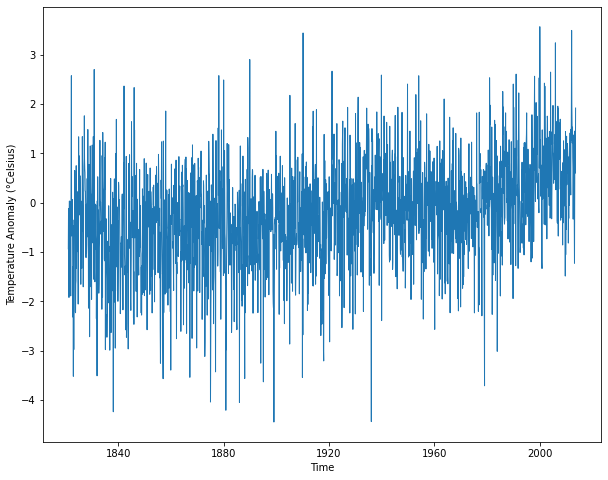

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 8))
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly (°Celsius)")
plt.plot(df_temp, linewidth=1.0)

In [16]:
df_temp.resample("A").mean().head()

,AverageAnomaly
Date,
1821-12-31,-0.933758
1822-12-31,-0.551008
1823-12-31,-1.026842
1824-12-31,-0.435592
1825-12-31,0.028658


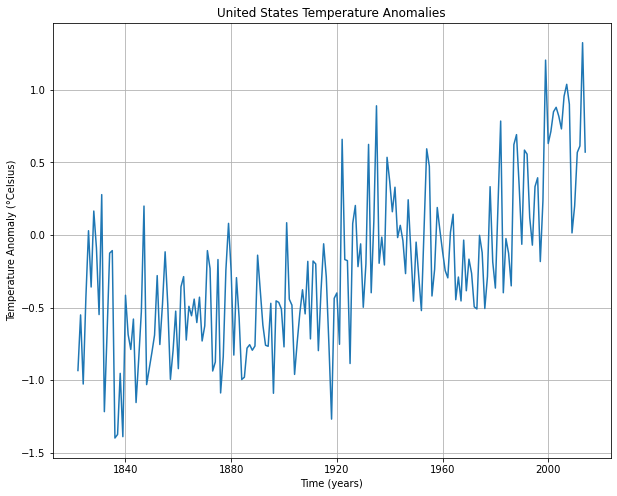

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

df_temp_resampled = df_temp.resample('A').mean()

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df_temp_resampled)
ax.set(xlabel="Time (years)", ylabel="Temperature Anomaly (°Celsius)", title="United States Temperature Anomalies")

ax.grid()

In [18]:
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [19]:
df_temp_resampled.iplot(kind="line", xTitle="Time (years)", yTitle="Temperature Anomaly (°Celsius)", title="United States Temperature Anomalies")

In [20]:
US_data.to_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\US_data.csv", index= False)

## Dataset 2 - Data Wrangling

In [21]:
# Filtering for 
CO_emissions = CO_emissions[(CO_emissions["country"] == "United States") & ((CO_emissions["year"] > 1957) & (CO_emissions["year"] < 2014))]
CO_emissions = CO_emissions.reset_index()
CO_emissions.drop(columns="index", inplace=True)

In [22]:
CO_emissions.head()

,iso_code,country,year,co2,consumption_co2,co2_growth_prct,co2_growth_abs,trade_co2,co2_per_capita,consumption_co2_per_capita,...,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,USA,United States,1958,2740.357,NaN,-3.11,-87.954,NaN,15.158,NaN,...,NaN,NaN,NaN,NaN,NaN,180788387.0,2.963550e+12,NaN,NaN,NaN
1,USA,United States,1959,2823.005,NaN,3.02,82.647,NaN,15.360,NaN,...,NaN,NaN,NaN,NaN,NaN,183786249.0,3.183157e+12,NaN,NaN,NaN
2,USA,United States,1960,2887.820,NaN,2.30,64.816,NaN,15.466,NaN,...,NaN,NaN,NaN,NaN,NaN,186720570.0,3.262376e+12,NaN,NaN,NaN
3,USA,United States,1961,2877.370,NaN,-0.36,-10.451,NaN,15.178,NaN,...,NaN,NaN,NaN,NaN,NaN,189569850.0,3.338584e+12,NaN,NaN,NaN
4,USA,United States,1962,2984.002,NaN,3.71,106.632,NaN,15.516,NaN,...,NaN,NaN,NaN,NaN,NaN,192313747.0,3.539745e+12,NaN,NaN,NaN


In [23]:
# Checking percentage of NaN values per column
CO_emissions.isna().sum() * 100 / len(CO_emissions)

# Copying columns with less than 50% NaN values
add_columns = CO_emissions[["primary_energy_consumption", "energy_per_capita", "energy_per_gdp"]]

# Dropping and rejoining DFs
CO_emissionsDropNA = CO_emissions.dropna(axis=1)
CO_emissionsDropNA = CO_emissionsDropNA.join(add_columns)
CO_emissions = CO_emissionsDropNA

In [24]:
# Checking percentage of NaN values per column
CO_emissions.isna().sum() * 100 / len(CO_emissions)

# Copying columns with less than 50% NaN values
add_columns = CO_emissions[["primary_energy_consumption", "energy_per_capita", "energy_per_gdp"]]

# Dropping and rejoining DFs
CO_emissionsDropNA = CO_emissions.dropna(axis=1)
CO_emissionsDropNA = CO_emissionsDropNA.join(add_columns)
CO_emissions = CO_emissionsDropNA

In [25]:
CO_emissions = CO_emissions[(CO_emissions["country"] == "United States") & ((CO_emissions["year"] > 1957) & (CO_emissions["year"] < 2014))]
CO_emissions = CO_emissions.reset_index()
CO_emissions.drop(columns="index", inplace=True)

In [26]:
CO_emissions.head()

,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,...,share_global_cumulative_cement_co2,share_global_cumulative_coal_co2,share_global_cumulative_flaring_co2,share_global_cumulative_gas_co2,share_global_cumulative_oil_co2,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,USA,United States,1958,2740.357,-3.11,-87.954,15.158,32.58,113406.447,39.30,...,36.13,33.62,47.23,89.10,58.23,180788387.0,2.963550e+12,NaN,NaN,NaN
1,USA,United States,1959,2823.005,3.02,82.647,15.360,31.90,116229.452,39.08,...,35.00,33.30,45.83,88.26,57.33,183786249.0,3.183157e+12,NaN,NaN,NaN
2,USA,United States,1960,2887.820,2.30,64.816,15.466,30.94,119117.272,38.83,...,33.76,32.98,44.76,87.27,56.34,186720570.0,3.262376e+12,NaN,NaN,NaN
3,USA,United States,1961,2877.370,-0.36,-10.451,15.178,30.75,121994.642,38.59,...,32.58,32.68,43.79,86.12,55.30,189569850.0,3.338584e+12,NaN,NaN,NaN
4,USA,United States,1962,2984.002,3.71,106.632,15.516,30.80,124978.644,38.36,...,31.44,32.41,42.52,84.87,54.22,192313747.0,3.539745e+12,NaN,NaN,NaN


In [27]:
print(CO_emissions.isna().sum())

iso_code                               0
country                                0
year                                   0
co2                                    0
co2_growth_prct                        0
co2_growth_abs                         0
co2_per_capita                         0
share_global_co2                       0
cumulative_co2                         0
share_global_cumulative_co2            0
co2_per_gdp                            0
coal_co2                               0
cement_co2                             0
flaring_co2                            0
gas_co2                                0
oil_co2                                0
cement_co2_per_capita                  0
coal_co2_per_capita                    0
flaring_co2_per_capita                 0
gas_co2_per_capita                     0
oil_co2_per_capita                     0
share_global_cement_co2                0
share_global_coal_co2                  0
share_global_flaring_co2               0
share_global_gas

In [28]:
columns=['iso_code', 'co2_growth_prct', 'co2_growth_abs', 'cumulative_co2', 'cumulative_cement_co2', 'cumulative_coal_co2', 
         'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_oil_co2', 'share_global_cumulative_co2', 
         'share_global_cumulative_cement_co2', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 
         'share_global_cumulative_gas_co2', 'share_global_cumulative_oil_co2', 'primary_energy_consumption', 'energy_per_capita', 
         'energy_per_gdp']

In [29]:
CO_emissions.drop(columns=columns, inplace=True)

In [30]:
print(CO_emissions.isna().sum())

country                     0
year                        0
co2                         0
co2_per_capita              0
share_global_co2            0
co2_per_gdp                 0
coal_co2                    0
cement_co2                  0
flaring_co2                 0
gas_co2                     0
oil_co2                     0
cement_co2_per_capita       0
coal_co2_per_capita         0
flaring_co2_per_capita      0
gas_co2_per_capita          0
oil_co2_per_capita          0
share_global_cement_co2     0
share_global_coal_co2       0
share_global_flaring_co2    0
share_global_gas_co2        0
share_global_oil_co2        0
population                  0
gdp                         0
dtype: int64


In [31]:
CO_emissions.fillna(method="bfill", inplace=True)

In [32]:
CO_emissions['year'] = pd.to_datetime(CO_emissions.year, format='%Y')
CO_emissions.drop(columns='country', inplace=True)
CO_emissions.set_index('year', inplace=True)

In [33]:
CO_emissions.head()

,co2,co2_per_capita,share_global_co2,co2_per_gdp,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,cement_co2_per_capita,...,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,population,gdp
year,,,,,,,,,,,,,,,,,,,,,
1958-01-01,2740.357,15.158,32.58,0.925,888.344,27.169,34.097,570.701,1220.046,0.150,...,0.189,3.157,6.748,20.84,18.70,35.85,80.76,44.70,180788387.0,2.963550e+12
1959-01-01,2823.005,15.360,31.90,0.887,910.978,29.604,30.756,593.210,1258.457,0.161,...,0.167,3.228,6.847,20.28,18.43,33.54,78.13,43.28,183786249.0,3.183157e+12
1960-01-01,2887.820,15.466,30.94,0.885,917.964,27.885,30.316,630.025,1281.631,0.149,...,0.162,3.374,6.864,17.77,17.89,34.01,75.42,41.04,186720570.0,3.262376e+12
1961-01-01,2877.370,15.178,30.75,0.862,887.443,27.998,28.198,636.415,1297.316,0.148,...,0.149,3.357,6.844,16.92,18.05,32.71,72.09,39.24,189569850.0,3.338584e+12
1962-01-01,2984.002,15.516,30.80,0.843,920.818,29.147,22.922,676.367,1334.748,0.152,...,0.119,3.517,6.940,16.40,18.79,26.67,69.82,37.56,192313747.0,3.539745e+12


Text(0, 0.5, 'Carbon Emissions Per Capita')

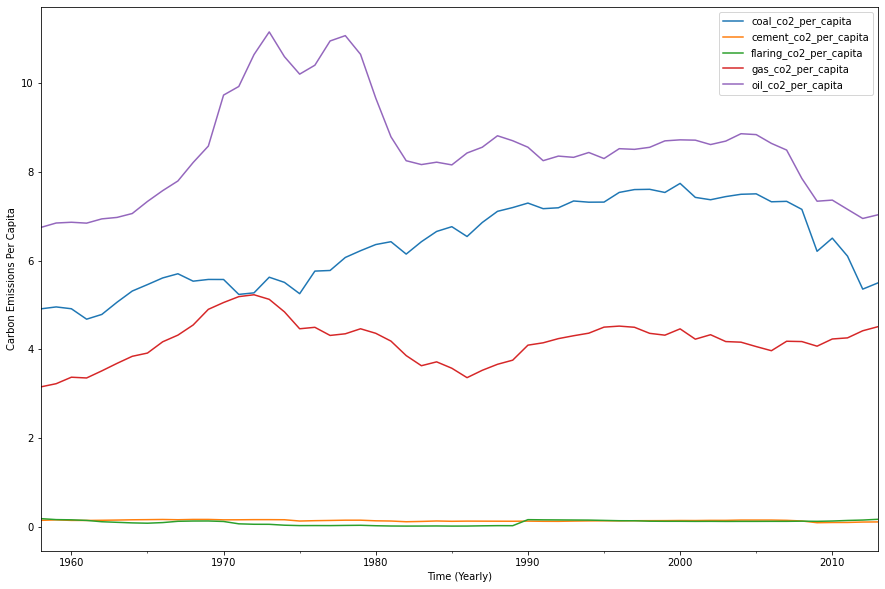

In [34]:
df_emissions = pd.DataFrame(CO_emissions, columns=["coal_co2_per_capita", "cement_co2_per_capita", 
                                                  "flaring_co2_per_capita", "gas_co2_per_capita",
                                                  "oil_co2_per_capita"])
df_emissions.plot(figsize=(15, 10))
plt.xlabel("Time (Yearly)")
plt.ylabel("Carbon Emissions Per Capita")

In [35]:
df_emissions.iplot(kind='line', xTitle='Time (years)', yTitle='Emissions (Metric Tons per Capita)', 
                  title='Global CO2 Emissions over Time')

<ipython-input-36-41208d35858f>:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



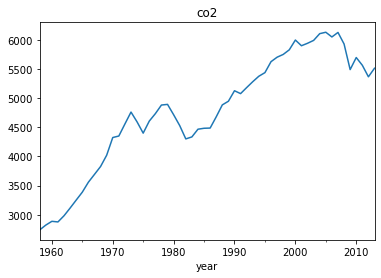

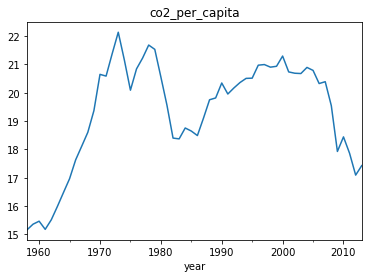

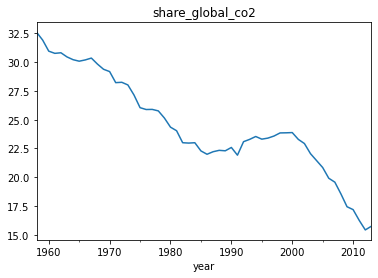

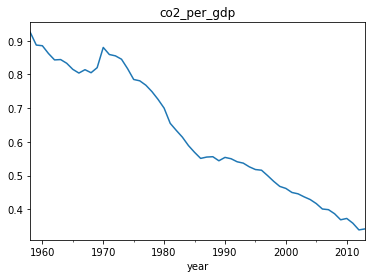

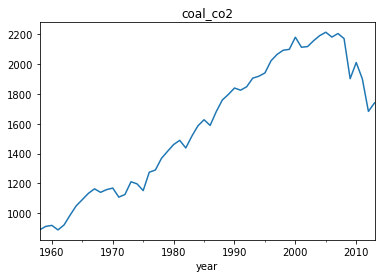

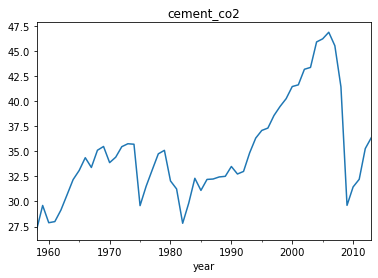

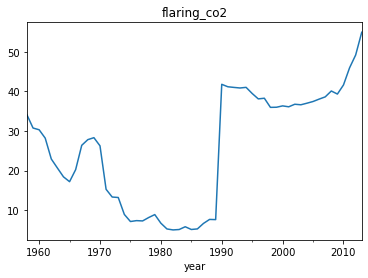

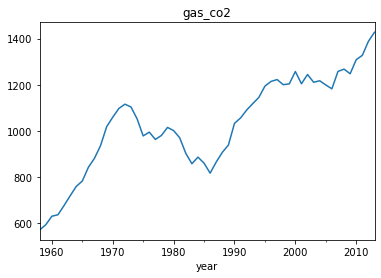

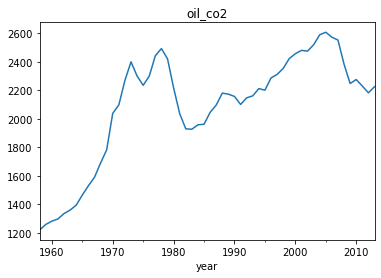

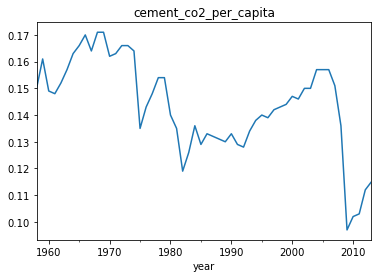

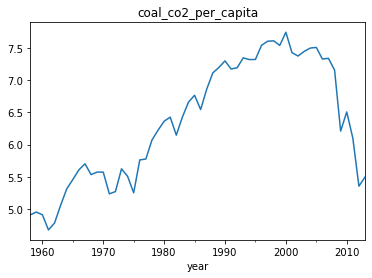

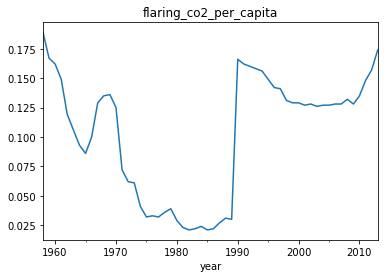

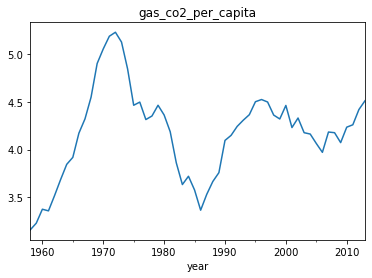

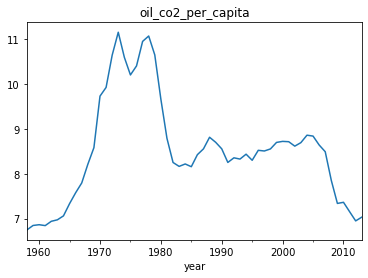

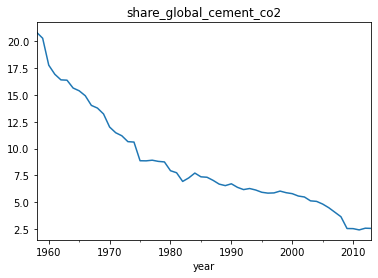

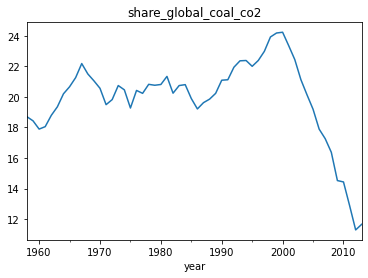

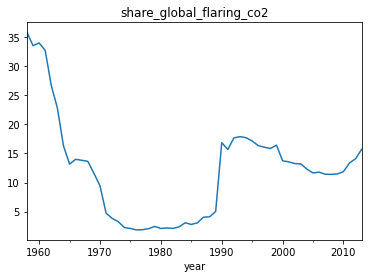

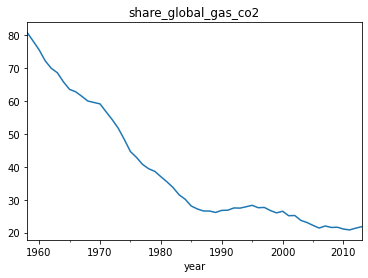

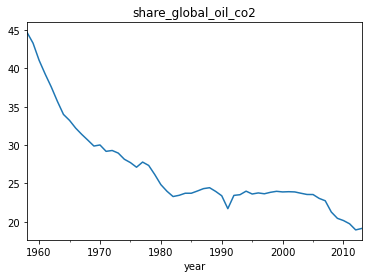

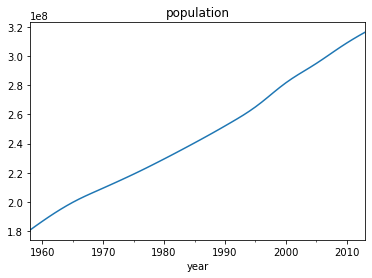

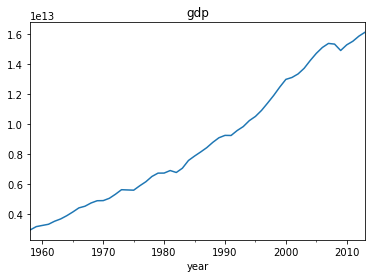

In [36]:
df_plot = CO_emissions
df_plot

for i, col in enumerate(df_plot.columns):
    df_plot[col].plot(fig=plt.figure(i))
    plt.title(col)
    
plt.show()

<AxesSubplot:>

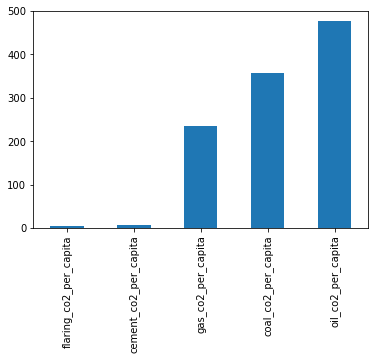

In [37]:
cols = ["coal_co2_per_capita", "cement_co2_per_capita", "flaring_co2_per_capita", "gas_co2_per_capita", "oil_co2_per_capita"]

CO2_per_source = df_emissions.sum().sort_values()
fig = plt.figure()
x_label = cols
x_tick = np.arange(len(cols))
CO2_per_source.plot(kind="bar")

In [38]:
CO_emissions.head()

,co2,co2_per_capita,share_global_co2,co2_per_gdp,coal_co2,cement_co2,flaring_co2,gas_co2,oil_co2,cement_co2_per_capita,...,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,share_global_cement_co2,share_global_coal_co2,share_global_flaring_co2,share_global_gas_co2,share_global_oil_co2,population,gdp
year,,,,,,,,,,,,,,,,,,,,,
1958-01-01,2740.357,15.158,32.58,0.925,888.344,27.169,34.097,570.701,1220.046,0.150,...,0.189,3.157,6.748,20.84,18.70,35.85,80.76,44.70,180788387.0,2.963550e+12
1959-01-01,2823.005,15.360,31.90,0.887,910.978,29.604,30.756,593.210,1258.457,0.161,...,0.167,3.228,6.847,20.28,18.43,33.54,78.13,43.28,183786249.0,3.183157e+12
1960-01-01,2887.820,15.466,30.94,0.885,917.964,27.885,30.316,630.025,1281.631,0.149,...,0.162,3.374,6.864,17.77,17.89,34.01,75.42,41.04,186720570.0,3.262376e+12
1961-01-01,2877.370,15.178,30.75,0.862,887.443,27.998,28.198,636.415,1297.316,0.148,...,0.149,3.357,6.844,16.92,18.05,32.71,72.09,39.24,189569850.0,3.338584e+12
1962-01-01,2984.002,15.516,30.80,0.843,920.818,29.147,22.922,676.367,1334.748,0.152,...,0.119,3.517,6.940,16.40,18.79,26.67,69.82,37.56,192313747.0,3.539745e+12


In [39]:
mte = CO_emissions["gas_co2_per_capita"]

In [40]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

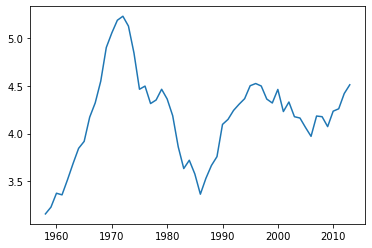

In [41]:
plt.plot(mte)

In [42]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks()
    plt.yticks()
    
    plt.xlabel('Time in Years')
    plt.ylabel('Total Emissions')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block= True)

In [43]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

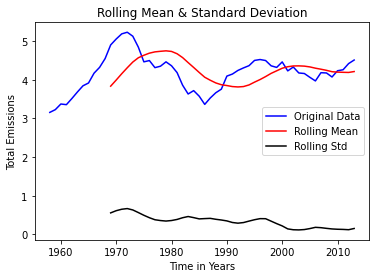

In [44]:
TestStationaryPlot(mte)

In [45]:
TestStationaryAdfuller(mte)

Test Statistic                 -3.614471
p-value                         0.005490
#Lags Used                      3.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [46]:
CO_emissions.to_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\CO_emissions.csv", index= False)